# Seattle Airbnb Data

## Section 1 : Business Understanding

We will try to understand Seattle Airbnb data in this notebook, trying to answer the below questions

#### Question 1. How are property prices distributed in Seattle ?
#### Question 2. Build a model to predict price based on important independent variables from the data
#### Question 3. What are customers talking about Airbnb Seattle ?

###########################################################################################

## Section 2 : Data Gathering

In [1]:
"""Importing necessary libraries"""
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import os,time
import datetime as dt
import gzip
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from wordcloud import STOPWORDS

import statsmodels.api as sm

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 100)

# Fetching directory path
data_file_path=os.path.dirname(os.path.dirname(os.path.abspath("__file__")))
print(data_file_path)

C:\Users\40100275\OneDrive - Anheuser-Busch InBev\Desktop\Udacity


##### Importing Seattle Airbnb datasets

In [2]:
"""The datasets are 3 csv files
1. Listings is a dataset which has a bunch of features of each property and price. 
    This dataset is unique at Listing_id level. 
2. Calendar is a dataset which has information at day level whether a property is available or occupied,
    and the price if available
3. Reviews has customer feedback and comments for each property along with date
"""

# Importing csv files
listings = pd.read_csv(data_file_path + '\\Project1 - AirBnB Data\\Seattle\\listings.csv')
calendar = pd.read_csv(data_file_path + '\\Project1 - AirBnB Data\\Seattle\\calendar.csv')
reviews = pd.read_csv(data_file_path + '\\Project1 - AirBnB Data\\Seattle\\reviews.csv')

In [3]:
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [4]:
calendar.describe()

,listing_id
count,1.393570e+06
mean,5.550111e+06
std,2.962274e+06
min,3.335000e+03
25%,3.258213e+06
50%,6.118244e+06
75%,8.035212e+06
max,1.034016e+07


## Section 3 :  Data Processing

No handles with labels found to put in legend.


Trend of Bookings% in 2016 has been declining


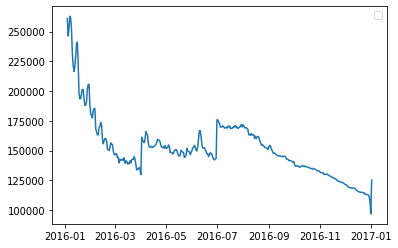

In [5]:
# Formatting price and date columns from calendar file
calendar["date"] = pd.to_datetime(calendar["date"], format='%Y-%m-%d')
calendar["price"] = calendar["price"].str.replace("$", "")
calendar["price"] = calendar["price"].str.replace(",", "")
calendar['price'] = pd.to_numeric(calendar['price'])
calendar = calendar.fillna(calendar.groupby(['listing_id']).transform('mean'))
# Assuming sales happened when availability in calendar is False, else sales is set to 0
calendar['Sales'] = np.where(calendar['available']=='f', calendar['price'] , 0)
#calendar.head()

# Calculating the actual sales perc for each listing in 2016
revlisting = calendar[['listing_id', 'price', 'Sales']].groupby('listing_id').sum().reset_index()
revlisting['Sales_perc'] = revlisting['Sales']/revlisting['price']
revlisting = revlisting[['listing_id', 'Sales_perc']]
# Replacing NaN values with 0
revlisting = revlisting.fillna(0)

# Vicusalizing Sales trendline across 2016
revTimeline = calendar[['date', 'price', 'Sales']].groupby('date').sum().reset_index()

print("Trend of Bookings% in 2016 has been declining")
# Plotting daily sales
plt.plot(revTimeline['date'], revTimeline['Sales'])
plt.legend()
plt.show()



In [6]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [7]:
reviews.describe()

,listing_id,id,reviewer_id
count,8.484900e+04,8.484900e+04,8.484900e+04
mean,3.005067e+06,3.058765e+07,1.701301e+07
std,2.472877e+06,1.636613e+07,1.353704e+07
min,4.291000e+03,3.721000e+03,1.500000e+01
25%,7.946330e+05,1.725127e+07,5.053141e+06
50%,2.488228e+06,3.228809e+07,1.413476e+07
75%,4.694479e+06,4.457648e+07,2.762402e+07
max,1.024814e+07,5.873651e+07,5.281274e+07


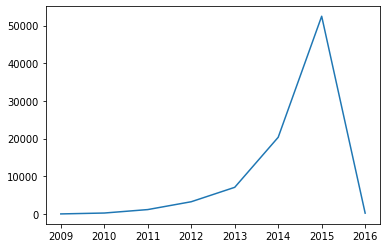

In [8]:
# Plotting no. of reviews per year

reviews['date'] = pd.to_datetime(reviews['date'], format='%Y-%m-%d')
reviews['Year'] = reviews['date'].dt.year
reviews_20152016 = reviews[reviews['Year']>=2015]
reviews_20152016 = reviews_20152016[['listing_id', 'comments']].groupby('listing_id').count().reset_index()
reviews_20152016 = reviews_20152016.rename(columns={'comments':'tot_num_reviews_201516'})

reviewstim = reviews[['Year', 'comments']].groupby('Year').count().reset_index()
plt.plot(reviewstim['Year'], reviewstim['comments'])
plt.show()


 The number of reviews peaked in 2015 compared to other years

In [9]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.639123,-122.365666,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazi

In [10]:
listings.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,guests_included,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,reviews_per_month
count,3.818000e+03,3.818000e+03,3.818000e+03,3816.000000,3816.000000,3818.000000,3818.000000,3818.000000,3802.000000,3812.000000,3817.000000,97.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3171.000000,3160.000000,3165.000000,3160.000000,3167.000000,3163.000000,3162.000000,0.0,3818.000000,3191.000000
mean,5.550111e+06,2.016010e+13,1.578556e+07,7.157757,7.157757,47.628961,-122.333103,3.349398,1.259469,1.307712,1.735394,854.618557,1.672603,2.369303,780.447617,16.786276,36.814825,58.082504,244.772656,22.223415,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,NaN,2.946307,2.078919
std,2.962660e+06,0.000000e+00,1.458382e+07,28.628149,28.628149,0.043052,0.031745,1.977599,0.590369,0.883395,1.139480,671.404893,1.311040,16.305902,1683.589007,12.173637,23.337541,34.063845,126.772526,37.730892,6.606083,0.698031,0.797274,0.595499,0.568211,0.629053,0.750259,NaN,5.893029,1.822348
min,3.335000e+03,2.016010e+13,4.193000e+03,1.000000,1.000000,47.505088,-122.417219,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,NaN,1.000000,0.020000
25%,3.258256e+06,2.016010e+13,3.275204e+06,1.000000,1.000000,47.609418,-122.354320,2.000000,1.000000,1.000000,1.000000,420.000000,1.000000,1.000000,60.000000,2.000000,13.000000,28.000000,124.000000,2.000000,93.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,NaN,1.000000,0.695000
50%,6.118244e+06,2.016010e+13,1.055814e+07,1.000000,1.000000,47.623601,-122.328874,3.000000,1.000000,1.000000,1.000000,750.000000,1.000000,2.000000,1125.000000,20.000000,46.000000,73.000000,308.000000,9.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,1.000000,1.540000
75%,8.035127e+06,2.016010e+13,2.590309e+07,3.000000,3.000000,47.662694,-122.310800,4.000000,1.000000,2.000000,2.000000,1200.000000,2.000000,2.000000,1125.000000,30.000000,59.000000,89.000000,360.000000,26.000000,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,2.000000,3.000000
max,1.034016e+07,2.016010e+13,5.320861e+07,502.000000,502.000000,47.733358,-122.240607,16.000000,8.000000,7.000000,15.000000,3000.000000,15.000000,1000.000000,100000.000000,30.000000,60.000000,90.000000,365.000000,474.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,37.000000,12.150000


In [11]:
### Formatting columns in listings dataset to convert them to numeric

listings["price"] = listings["price"].str.replace("$", "")
listings["price"] = listings["price"].str.replace(",", "")
listings['price'] = pd.to_numeric(listings['price'])
listings["host_response_rate"] = listings["host_response_rate"].str.replace("%", "")
listings['host_response_rate'] = pd.to_numeric(listings['host_response_rate'])
listings['last_scraped'] = pd.to_datetime(listings['last_scraped'], format='%Y-%m-%d')
listings['first_review'] = pd.to_datetime(listings['first_review'], format='%Y-%m-%d')
calendar["date"] = pd.to_datetime(calendar["date"], format='%Y-%m-%d')
listings['age'] = (listings['last_scraped'] - listings['first_review']).dt.days
#listings.head()

In [12]:
### Merging reviews and bookings information to listings

MasterData = listings.merge(reviews_20152016, how = 'left', left_on='id', right_on='listing_id')
MasterData = MasterData.merge(revlisting, how = 'left', left_on='id', right_on='listing_id')

dums1 = pd.get_dummies(MasterData['room_type'])
MasterData = pd.concat([MasterData, dums1], axis=1)

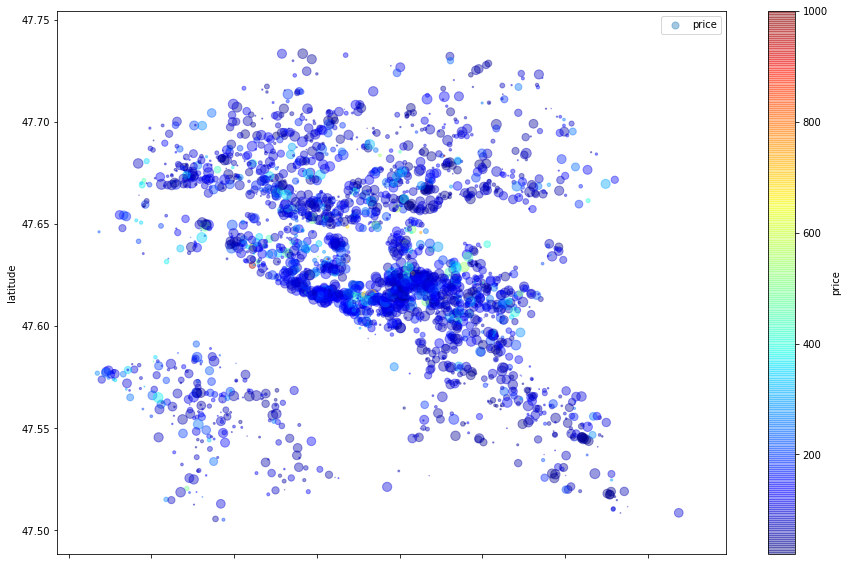

In [13]:
"""Plotting properties based on latitude and longitude
Color scale represents price
Size of bubble represents Booking % in 2016
"""

datageo = MasterData[MasterData['city']=='Seattle']
datageo.plot(kind="scatter", x="longitude", y="latitude",
    s=datageo['Sales_perc']*100, label="price",
    c="price", cmap=plt.get_cmap("jet"),
    colorbar=True, alpha=0.4, figsize=(15,10),
)
plt.legend()
plt.show()

Properties with higher price has lower booking rates

### Counting Null values in columns

In [14]:
MasterData.isnull().sum().sort_values(ascending=False)

license                             3818
square_feet                         3721
monthly_price                       2301
security_deposit                    1952
weekly_price                        1809
notes                               1606
neighborhood_overview               1032
cleaning_fee                        1030
transit                              934
host_about                           859
host_acceptance_rate                 773
listing_id_x                         707
tot_num_reviews_201516               707
review_scores_checkin                658
review_scores_accuracy               658
review_scores_value                  656
review_scores_location               655
review_scores_cleanliness            653
review_scores_communication          651
review_scores_rating                 647
age                                  627
reviews_per_month                    627
last_review                          627
first_review                         627
space           

In [15]:
"""Define X and y varibles for our model"""

dep_var = 'price'
SL_vars = [ 'host_total_listings_count',  'accommodates', 'bathrooms', 'bedrooms', 'host_response_rate', \
           'Entire home/apt', 'Shared room', \
           'review_scores_value', 'reviews_per_month', 'guests_included', 'Sales_perc' ]

Model_Data = MasterData

print("The shape of the Modeling dataset is ", Model_Data.shape)


The shape of the Modeling dataset is  (3818, 100)


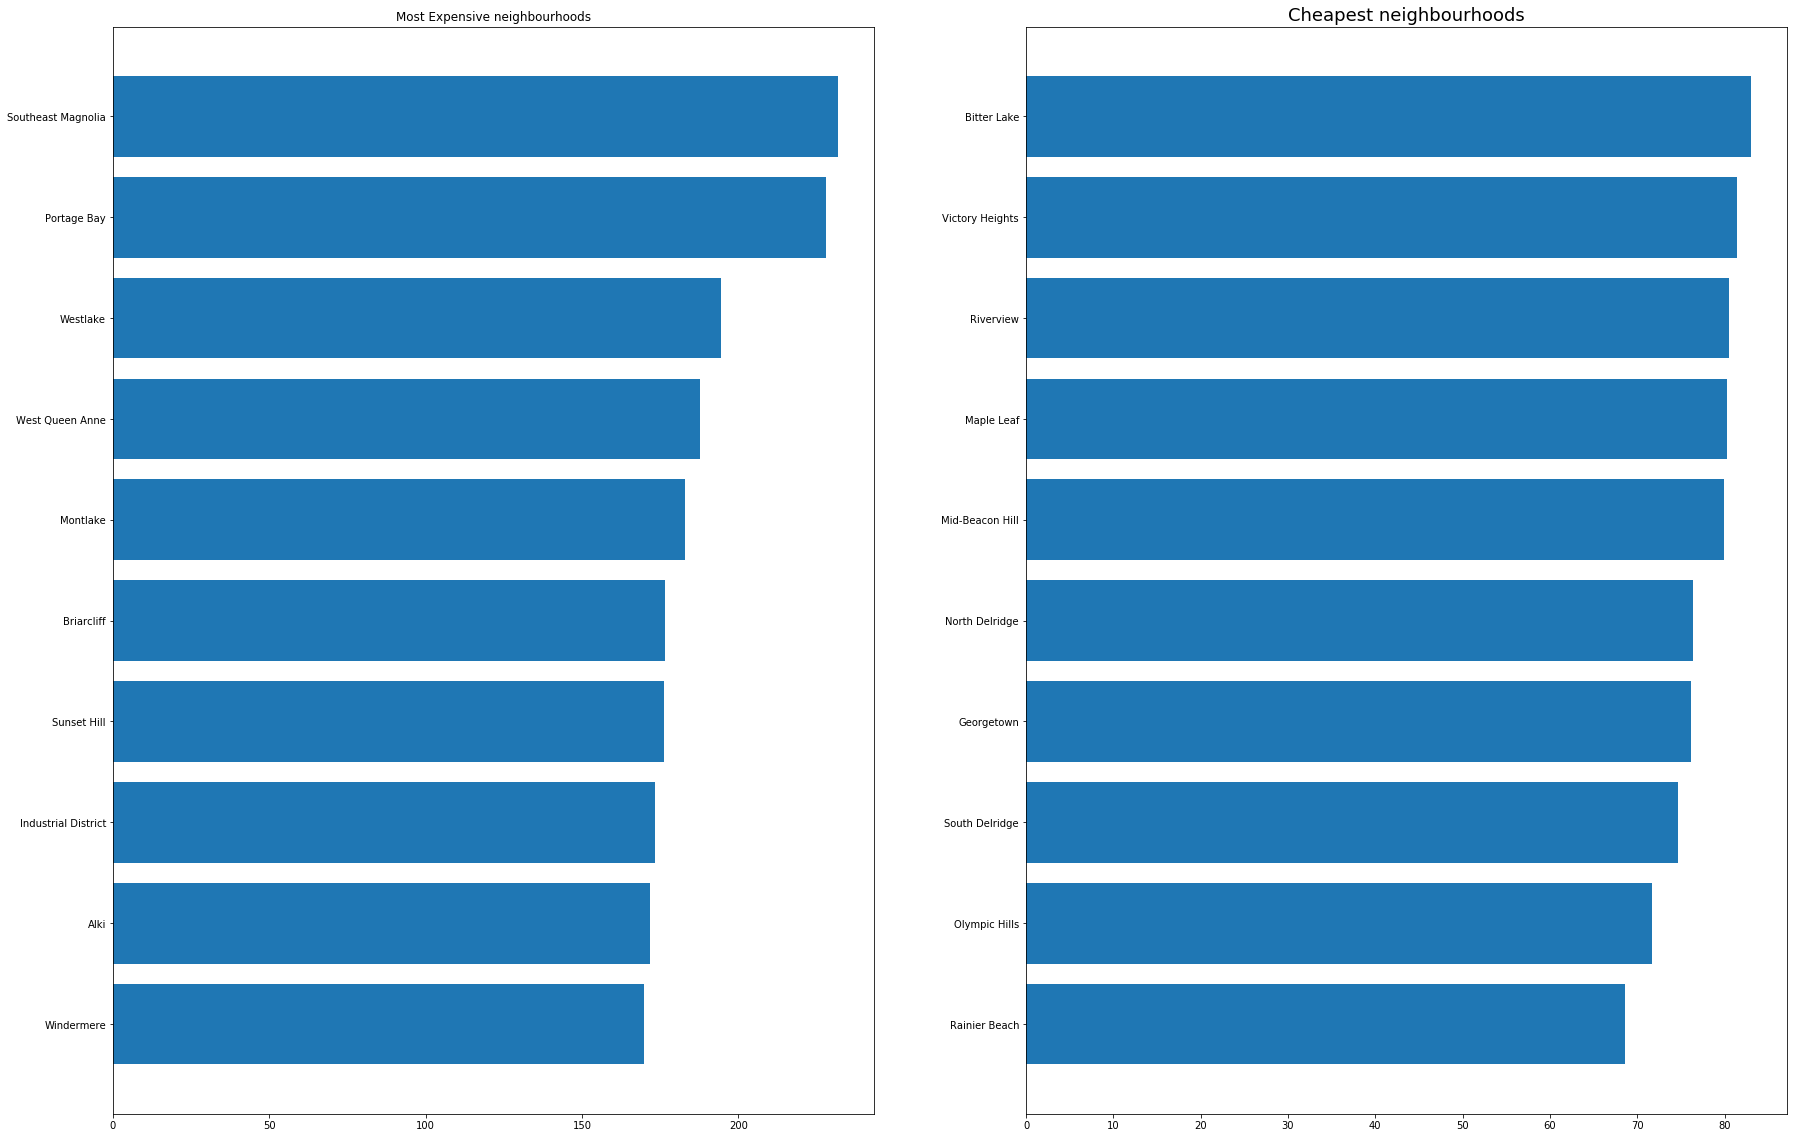

In [16]:
font = {'size'   : 15}

mdx1 = Model_Data[['neighbourhood_cleansed', 'price', 'number_of_reviews', 'review_scores_rating']].groupby('neighbourhood_cleansed').mean().reset_index()
mdx2 = Model_Data[['neighbourhood_cleansed', 'square_feet']].groupby('neighbourhood_cleansed').count().reset_index()
mdx1 = mdx1.merge(mdx2, how='left', on='neighbourhood_cleansed')
mdx3 = mdx1.sort_values(by='price', ascending=True)[mdx1.shape[0]-10:mdx1.shape[0]]
mdx4 = mdx1.sort_values(by='price', ascending=True)[0:10]

fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(30, 20))

ax1.barh(mdx3['neighbourhood_cleansed'], mdx3['price'])
ax1.set_title('Most Expensive neighbourhoods')
plt.rc('font', **font)

ax2.barh(mdx4['neighbourhood_cleansed'], mdx4['price'])
ax2.set_title('Cheapest neighbourhoods')
plt.rc('font', **font)

Baircliff, Sunset Hill and Industrial District have the highest prices of propertieswiwith avg rent of $170

Rainier Beach, Olymic Hills and South Delridge are the cheapest with approx $70 as average rent

#### Distribution of Price 

Mean of Price is :  127.97616553169199
Median of Price is :  100.0
Mode of Price is :  0    150.0
dtype: float64


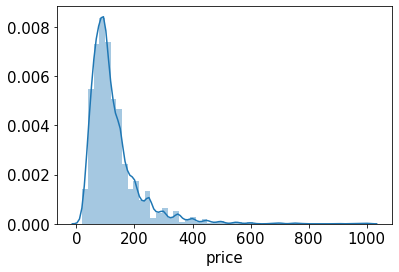

In [17]:
sns.distplot(Model_Data[dep_var])
print("Mean of Price is : ", Model_Data[dep_var].mean())
print("Median of Price is : ", Model_Data[dep_var].median())
print("Mode of Price is : ", Model_Data[dep_var].mode())

The prices of properties is right skewed with average price being $128

Few properties have rents above $500. These outliars can be removed from the dataset

Text(0.5, 1.0, 'Price vs. Guests included')

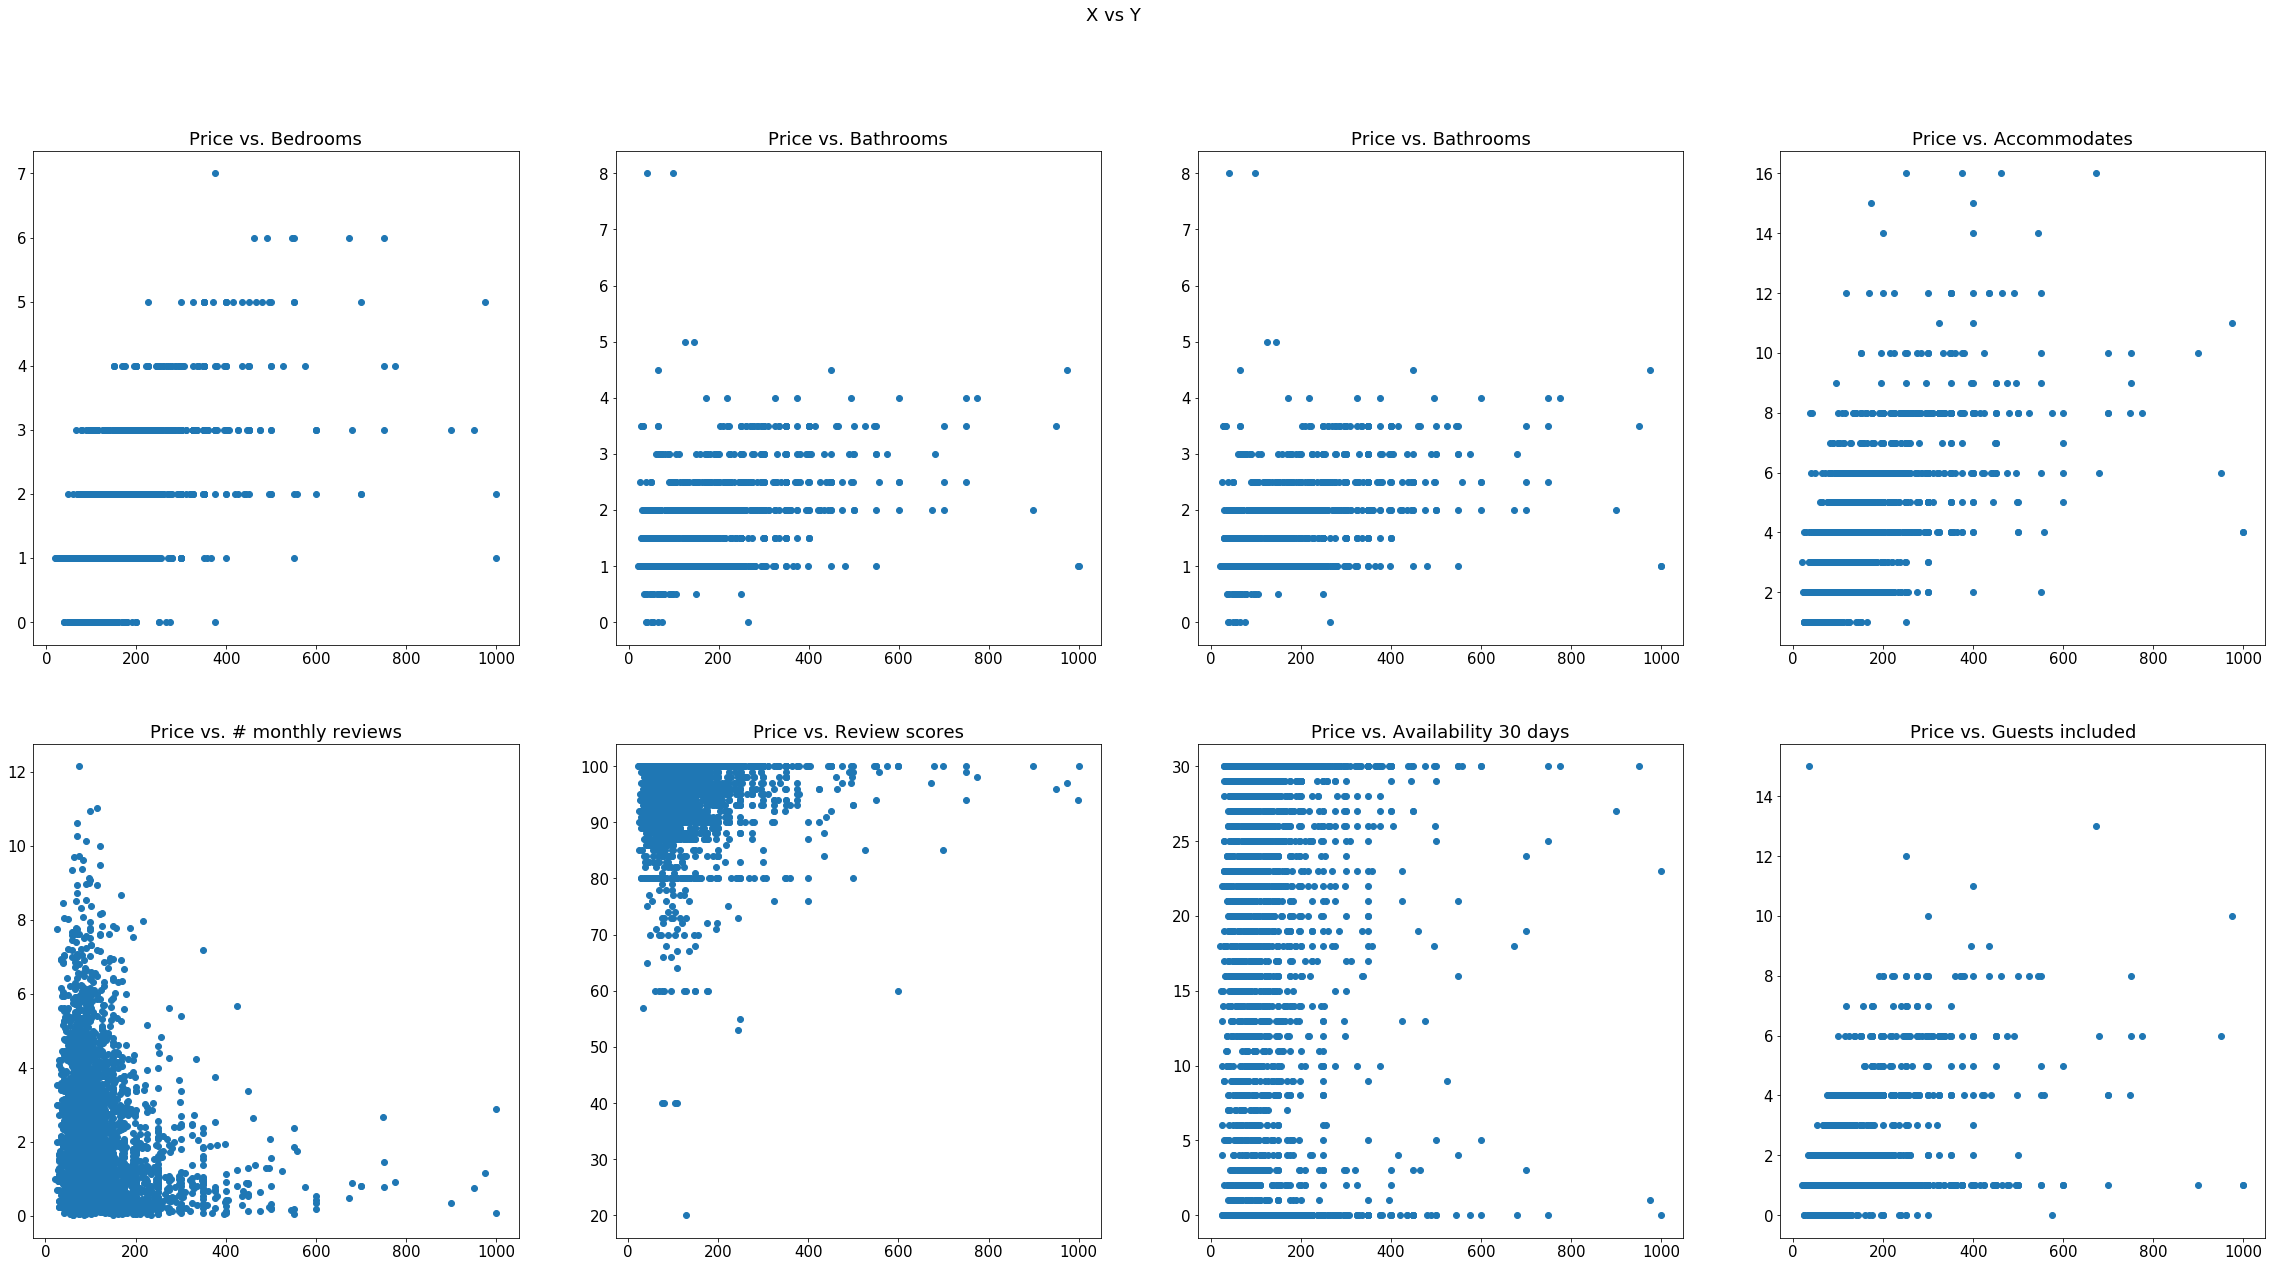

In [18]:
### Price vs Independent variables scayyer plots

fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(40, 20))
fig.suptitle('X vs Y')

ax1.scatter(listings['price'], listings['bedrooms'])
ax1.set_title('Price vs. Bedrooms')

ax2.scatter(listings['price'], listings['bathrooms'])
ax2.set_title('Price vs. Bathrooms')

ax3.scatter(listings['price'], listings['bathrooms'])
ax3.set_title('Price vs. Bathrooms')

ax4.scatter(listings['price'], listings['accommodates'])
ax4.set_title('Price vs. Accommodates')

ax5.scatter(listings['price'], listings['reviews_per_month'])
ax5.set_title('Price vs. # monthly reviews')

ax6.scatter(listings['price'], listings['review_scores_rating'])
ax6.set_title('Price vs. Review scores')

ax7.scatter(listings['price'], listings['availability_30'])
ax7.set_title('Price vs. Availability 30 days')

ax8.scatter(listings['price'], listings['guests_included'])
ax8.set_title('Price vs. Guests included')

Number of Bedrooms, bathrooms and Accommodations have a weak linear relationship with Price

In [19]:
"""Filtering out till 99% quartiles of Price """

q = Model_Data[dep_var].quantile(0.99)
Model_Data = Model_Data[Model_Data[dep_var]<=q]
Model_Data = Model_Data[Model_Data[dep_var]>0]


### Correlation plot

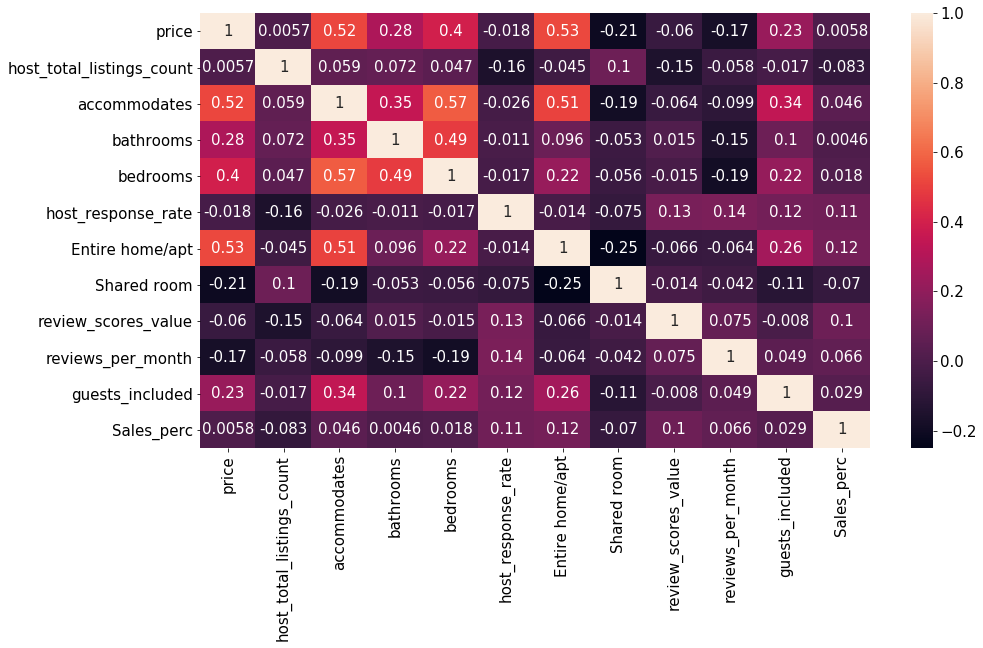

In [20]:
"""Correlation matrix for the data"""

corr = Model_Data[[dep_var] + SL_vars ].corr(method='kendall')
plt.figure(figsize=(15,8))
sns.heatmap(corr, annot=True)
#Model_Data.columns

The above correlation plot suggest Price is correlated the most with number of accomodations, the poperty being an entire home / apartment, number of bedrroms and bathrooms

In [21]:
print("There are ", Model_Data.shape[0], 'rows in the dataset.')
print("There are ", Model_Data.shape[1], 'columns in the dataset.')

There are  3780 rows in the dataset.
There are  100 columns in the dataset.


## Section 4 :Linear Regression model

In [22]:
X_SL = Model_Data[SL_vars]
y = Model_Data[dep_var]

#### Scaling our data using MinMax scaler to bring all variables in similar scale
scaler = MinMaxScaler(feature_range=(0, 1))
Test = scaler.fit_transform(X_SL)
Test = X_SL
X_SL = X_SL.fillna(0)

### Log transforing y variable to remove skewness in data
y = np.log(y)
### Replacing infinity values with 0
y = y.replace([np.inf, -np.inf],0)
### Replacing NaN values with 0
y = y.fillna(0)

# #Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X_SL, y, test_size=0.2, random_state=42)

lm_model = LinearRegression(normalize=False) # Instantiate
lm_model.fit(X_train, y_train) #Fit
        
#Predict and score the model
y_test_preds = lm_model.predict(X_test) 
y_train_preds = lm_model.predict(X_train) 


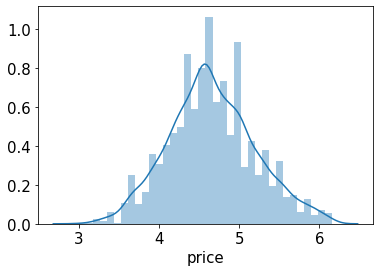

In [23]:
sns.distplot(y)

After taking a log transformation, price variable is more normally distributed and problem of skewness is taken care of

## Section 5 : Model Results and validation

In [24]:
### Model results are validated on the Test set using R2 and RMSE

print("The Train R2 is : ", r2_score(y_train, y_train_preds))
print("The Test R2 is : ", r2_score(y_test, y_test_preds))
print("Train RMSE : ",(np.sqrt(mean_squared_error(y_train, y_train_preds))))
print("Test RMSE : ",(np.sqrt(mean_squared_error(y_test, y_test_preds))))

The Train R2 is :  0.6127665750492175
The Test R2 is :  0.6455294301172081
Train RMSE :  0.3345241589806647
Test RMSE :  0.3263625368878889


In [25]:
lm_model.predict(X_test[:1])

array([3.7950699])

In [26]:
y_test[:1]

851    4.094345
Name: price, dtype: float64

In [27]:
### Model coefficients

coef_dict = dict(zip(SL_vars, lm_model.coef_))
coef_dict

{'host_total_listings_count': 0.0006736440868440839,
 'accommodates': 0.05714413284687769,
 'bathrooms': 0.08175953157994799,
 'bedrooms': 0.1334105242716268,
 'host_response_rate': -0.001629147944575825,
 'Entire home/apt': 0.47169630320540373,
 'Shared room': -0.43270651028444934,
 'review_scores_value': 0.0017666015313560954,
 'reviews_per_month': -0.022154134085562965,
 'guests_included': 0.01569514170201777,
 'Sales_perc': -0.10085006783204072}

In [28]:
"""Testing for significance of independent variables"""
mod = sm.OLS(y,X_SL)
fii = mod.fit()
p_values = fii.summary2().tables[1]['P>|t|']
p_values

host_total_listings_count     3.731278e-01
accommodates                  3.773023e-02
bathrooms                    1.580616e-145
bedrooms                      1.181568e-07
host_response_rate           2.210405e-130
Entire home/apt              3.341193e-128
Shared room                   1.339314e-03
review_scores_value          7.257395e-116
reviews_per_month             8.594834e-03
guests_included               1.077242e-06
Sales_perc                    4.423079e-32
Name: P>|t|, dtype: float64

### Reviews of properties in Seattle

In [29]:
"""Creating a wordcloud from comments in reviews dataset"""

reviews1 = reviews.merge(listings[['id', 'property_type', 'market']], how='left', left_on='listing_id', right_on='id').reset_index()

def wclouds(x, stpwrds):
    """This function creates a wordcloud based on text. x is an argument which takes a column as input
    Values of this list are joined to create 1 single string which is passed to a wordcloud library.
    The 2nd argument is a list of words which will be filtered out while building results"""

    text = " ".join(str(review) for review in x)
    stopwords = set(STOPWORDS)
    stopwords.update(stpwrds)

    plt.subplots(figsize=(25,15))
    wordcloud = WordCloud(
                            stopwords=stopwords,                      
                            background_color='white',
                            width=1080,
                            height=1080
                          ).generate(text)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()


reviews1.property_type.unique()

array(['Apartment', 'House', 'Townhouse', 'Condominium', 'Loft',
       'Bungalow', 'Cabin', 'Bed & Breakfast', 'Boat', 'Other',
       'Camper/RV', 'Treehouse', 'Tent', 'Dorm', 'Chalet', 'Yurt'],
      dtype=object)

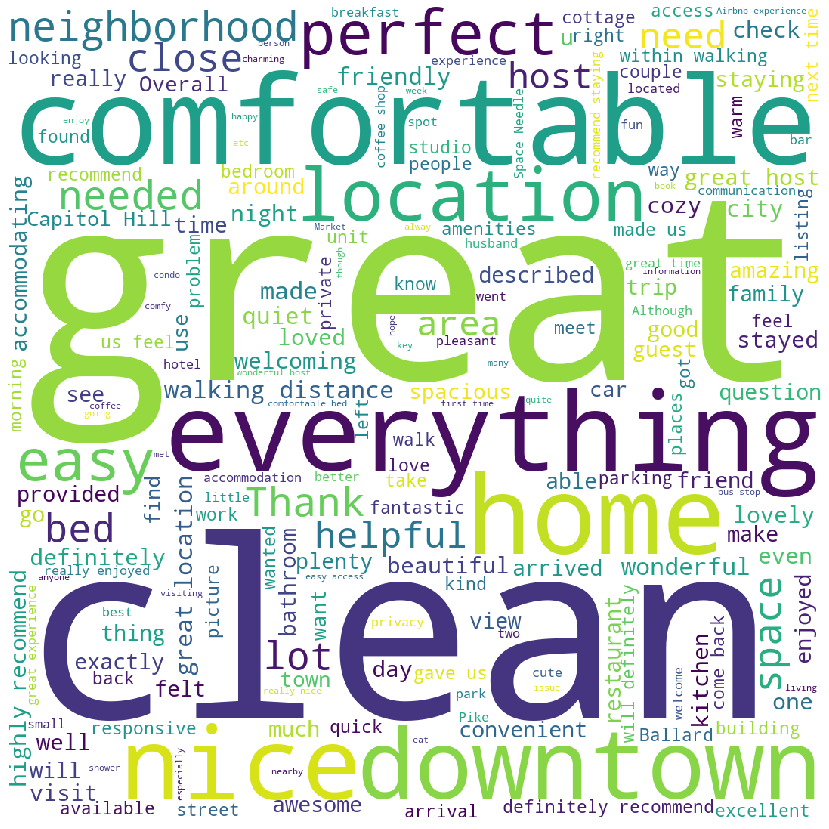

In [30]:
### Fitering data to have records only for Seattle market

reviews_temp = reviews1[reviews1['market'].isin(['Seattle'])]

### Define words which should not apper in wordcloud
wclouds(reviews_temp.comments, ['Seattle', 'Boston', 'stay', 'place', 'room', 'apartment', 'house'])

The most popular comments for Seattle Airbnb data indicate that positive sentiments.

People think these properties are doing great

There are mentions of cleanliness, comfort, accessibilty.

Most of the keywords indicate postive sentiments in the comments about the properties

Lets look at what are people talking about for the property which has most number of comments in AirBnB

In [31]:
### Lets find the listing with highest number of comments

reviews1_t = reviews1.groupby('listing_id').count().sort_values(by='comments', ascending=False).reset_index()
reviews1_t['listing_id'][0]

208356

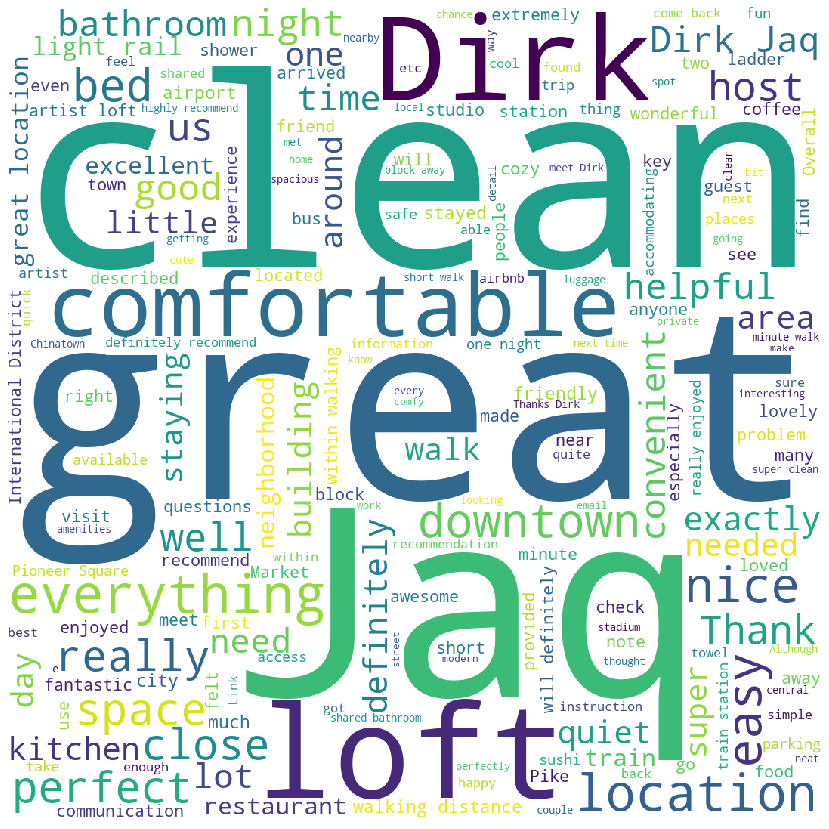

In [32]:
### Reviews for specific properties can be similary filtered out

reviews2 = reviews1[reviews1['listing_id'].isin(['208356'])]

### Define words which should not apper in wordcloud
wclouds(reviews2.comments, ['Seattle', 'Boston', 'stay', 'place', 'room', 'apartment', 'house'])

Similar sentiments can be seen for the comments on the particular listing

The mentions indicate postive sentiments

END